In [285]:
from sklearn.metrics import f1_score,recall_score,accuracy_score,precision_score
def all_scores(predicts, test_y):
    print(f"Accuracy Score: {accuracy_score(test_y,predicts):.3f}\nRecall Score: {recall_score(test_y,predicts):.3f}\nPrecision Score: {precision_score(test_y,predicts):.3f}\nF1 Score: {f1_score(test_y,predicts):.3f}\n")
def scores(validation_results):
    media = validation_results['test_score'].mean()
    desvio_padrao = validation_results['test_score'].std()
    print("Accuracy médio {:.2f}".format(media))
    print("Intervalo [{:.2f}, {:.2f}]".format((media - 2 * desvio_padrao), (media + 2 * desvio_padrao)))


In [313]:
import pandas as pd
import numpy as np
import pandas_profiling
np.random.seed(1010)
data = pd.read_csv('../dataset_customer_churn.csv', sep='^')
data.drop(labels=['A006_REGISTRO_ANS','CODIGO_BENEFICIARIO', 'CLIENTE', 'CD_USUARIO', 'CODIGO_FORMA_PGTO_MENSALIDADE', 'CD_ASSOCIADO', 'A006_NM_PLANO', 'ESTADO_CIVIL'], axis=1, inplace=True)
is_NAN = data[data.isna().any(axis=1)]
data.drop(is_NAN.index, axis=0, inplace=True)
data.sample(20)

,NUM_BENEFICIARIOS_FAMILIA,SITUACAO,IDADE,SEXO,QTDE_DIAS_ATIVO,QTDE_ATENDIMENTOS,QTDE_ATO_COBERTO_EXECUTADO,QTDE_ATO_N_COBERTO_EXECUTADO,REALIZOU_ENDODONTIA_COBERTA,REALIZOU_EXODONTIA_COBERTA,REALIZOU_PROCEDIMEN_ALTO_CUSTO,DIAS_ATE_REALIZAR_ALTO_CUSTO,FORMA_PGTO_MENSALIDADE,PLANO
349882,1.0,ATIVO,18.0,F,136.0,5.0,9.0,0.0,NAO,NAO,NAO,NaoRealizou,boleto,481485181
39949,4.0,DESATIVADO,41.0,F,1349.0,12.0,43.0,14.0,SIM,SIM,SIM,200+,debito automatico,703454997
86627,7.0,ATIVO,45.0,M,1790.0,2.0,5.0,0.0,NAO,NAO,NAO,NaoRealizou,boleto,475840164
59031,3.0,DESATIVADO,80.0,F,27.0,0.0,0.0,0.0,NAO,NAO,NAO,NaoRealizou,boleto,475840164
280026,2.0,ATIVO,26.0,F,134.0,1.0,5.0,0.0,NAO,NAO,NAO,NaoRealizou,cartao de credito,475441167
207229,4.0,DESATIVADO,43.0,F,298.0,0.0,0.0,0.0,NAO,NAO,NAO,NaoRealizou,cartao de credito,475441167
212253,1.0,DESATIVADO,29.0,F,148.0,4.0,15.0,0.0,NAO,SIM,SIM,15-30,boleto,475441167
12122,2.0,DESATIVADO,54.0,F,341.0,4.0,16.0,9.0,NAO,NAO,SIM,91-200,boleto,408875991
208541,2.0,DESATIVADO,87.0,M,585.0,0.0,0.0,0.0,NAO,NAO,NAO,NaoRealizou,boleto,475840164
167535,1.0,DESATIVADO,13.0,M,95.0,0.0,0.0,0.0,NAO,NAO,NAO,NaoRealizou,boleto,475840164


KeyError: 'DIAS_ATE_REALIZAR_ALTO_CUSTO'

In [303]:
dict_replace = {
    "SIM": 1,
    "NAO": 0,
    'F': 0,
    'M': 1,
    'DESATIVADO': 1,
    'ATIVO': 0,

}
data.replace(dict_replace, inplace=True)


1    5720
Name: DIAS_ATE_REALIZAR_ALTO_CUSTO_31-60, dtype: int64

In [297]:
dict_replace = {
    "SIM": 1,
    "NAO": 0,
    'F': 0,
    'M': 1,
    'DESATIVADO': 1,
    'ATIVO': 0,

}
data.replace(dict_replace, inplace=True)
data.drop(182212, axis=0, inplace=True)


In [278]:
QTDE_DIAS_ATIVO_MENOR_QUE_365 = np.array(data['QTDE_DIAS_ATIVO'] < 365)
data['QTDE_DIAS_ATIVO_MENOR_QUE_365'] = 0
data.loc[QTDE_DIAS_ATIVO_MENOR_QUE_365,'QTDE_DIAS_ATIVO_MENOR_QUE_365'] = 1
QTDE_DIAS_ATIVO_MENOR_QUE_1000 = np.array((data['QTDE_DIAS_ATIVO'] >= 365) & (data['QTDE_DIAS_ATIVO'] < 1000))
data['QTDE_DIAS_ATIVO_MENOR_QUE_1000'] = 0
data.loc[QTDE_DIAS_ATIVO_MENOR_QUE_1000, 'QTDE_DIAS_ATIVO_MENOR_QUE_1000'] = 1
QTDE_DIAS_ATIVO_MAIOR_QUE_1000 = np.array(data['QTDE_DIAS_ATIVO'] >= 1000)
data['QTDE_DIAS_ATIVO_MAIOR_QUE_1000'] = 0
data.loc[QTDE_DIAS_ATIVO_MAIOR_QUE_1000, 'QTDE_DIAS_ATIVO_MAIOR_QUE_1000'] = 1
data.drop(labels='QTDE_DIAS_ATIVO', axis=1, inplace=True)

In [279]:
data_dummified = pd.get_dummies(data)
data_dummified

,NUM_BENEFICIARIOS_FAMILIA,SITUACAO,IDADE,SEXO,QTDE_ATENDIMENTOS,QTDE_ATO_COBERTO_EXECUTADO,QTDE_ATO_N_COBERTO_EXECUTADO,REALIZOU_ENDODONTIA_COBERTA,REALIZOU_EXODONTIA_COBERTA,REALIZOU_PROCEDIMEN_ALTO_CUSTO,...,PLANO_422427992,PLANO_475441167,PLANO_475840164,PLANO_476697161,PLANO_476698169,PLANO_481484183,PLANO_481485181,PLANO_484629190,PLANO_703454997,PLANO_OUTROS
0,1.0,1,40.0,0,1.0,8.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,1,56.0,0,2.0,10.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2.0,1,66.0,0,18.0,73.0,8.0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3.0,1,62.0,1,1.0,1.0,0.0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1.0,1,47.0,1,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386387,2.0,0,26.0,0,2.0,11.0,0.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
386388,1.0,0,42.0,1,1.0,1.0,0.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
386389,2.0,0,32.0,1,3.0,7.0,0.0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
386390,1.0,1,37.0,0,1.0,5.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [280]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier
x = data_dummified.drop(labels=['SITUACAO'], axis=1)
y = data_dummified['SITUACAO']
np.random.seed(1010)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, stratify=y)

In [281]:
random_forest_classifier = RandomForestClassifier(10)
random_forest_classifier.fit(train_x,train_y)

RandomForestClassifier(n_estimators=10)

In [282]:
predicts_rfc = random_forest_classifier.predict(test_x)

all_scores(predicts_rfc, test_y)

Accuracy Score: 0.828
Recall Score: 0.903
Precision Score: 0.838
F1 Score: 0.869



In [283]:
feature_importances = random_forest_classifier.feature_importances_
feature_importance_df = pd.Series(feature_importances, index=pd.Series([col for col in x.columns]))
feature_importance_df * 100

NUM_BENEFICIARIOS_FAMILIA                    4.040513
IDADE                                       17.339454
SEXO                                         0.749730
QTDE_ATENDIMENTOS                            3.959162
QTDE_ATO_COBERTO_EXECUTADO                   6.405765
QTDE_ATO_N_COBERTO_EXECUTADO                 0.551345
REALIZOU_ENDODONTIA_COBERTA                  2.925275
REALIZOU_EXODONTIA_COBERTA                   0.497823
REALIZOU_PROCEDIMEN_ALTO_CUSTO               3.168741
QTDE_DIAS_ATIVO_MENOR_QUE_365                0.955139
QTDE_DIAS_ATIVO_MENOR_QUE_1000               1.215493
QTDE_DIAS_ATIVO_MAIOR_QUE_1000               0.689743
DIAS_ATE_REALIZAR_ALTO_CUSTO_0-14            0.071965
DIAS_ATE_REALIZAR_ALTO_CUSTO_15-30           0.032246
DIAS_ATE_REALIZAR_ALTO_CUSTO_200+            0.200357
DIAS_ATE_REALIZAR_ALTO_CUSTO_31-60           0.055622
DIAS_ATE_REALIZAR_ALTO_CUSTO_61-90           0.097071
DIAS_ATE_REALIZAR_ALTO_CUSTO_91-200          0.230608
DIAS_ATE_REALIZAR_ALTO_CUSTO

In [253]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, KFold
tt_x, val_x, tt_y, val_y = train_test_split(x, y, test_size=0.2, stratify=y)
### hiper-parametrização (?)
parametros_para_RSCV = {
    "max_depth" : randint(3, 100),
    "min_samples_split": randint(2, 16),
    "min_samples_leaf": randint(1, 16),
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]
}

RSCross_validation = RandomizedSearchCV(RandomForestClassifier(n_estimators=10), parametros_para_RSCV, n_iter= 16, cv = KFold(n_splits = 5, shuffle=True))
RSCross_validation.fit(tt_x,tt_y)
resultados = pd.DataFrame(RSCross_validation.cv_results_)


KeyboardInterrupt



In [ ]:
best_random_forest = RSCross_validation.best_estimator_
predicts_rfc = best_random_forest.predict(val_x)
all_scores(predicts_rfc, val_y)

In [ ]:
feature_importances = random_forest_classifier.feature_importances_
feature_importance_df = pd.Series(feature_importances, index=pd.Series([col for col in x.columns]))
feature_importance_df * 100

In [16]:
feature_importance_df = pd.Series(feature_importances, index=pd.Series([col for col in x.columns]))
feature_importance_df * 100

NUM_BENEFICIARIOS_FAMILIA      4.230150
IDADE                         16.445295
SEXO                           0.841267
QTDE_ATENDIMENTOS              3.995552
QTDE_ATO_COBERTO_EXECUTADO     4.706514
                                ...    
PLANO_481484183                1.132975
PLANO_481485181                0.280964
PLANO_484629190                0.178247
PLANO_703454997                0.416821
PLANO_OUTROS                   0.119362
Length: 156, dtype: float64

In [82]:
ESTADO_CIVIL = []
for feature in feature_importance_df.index:
    if feature[:4] == 'ESTA':
        ESTADO_CIVIL.append(feature)
ESTADO_CIVIL

['ESTADO_CIVIL_Indefinido',
 'ESTADO_CIVIL_amasiado',
 'ESTADO_CIVIL_casado',
 'ESTADO_CIVIL_convivente',
 'ESTADO_CIVIL_desquitado',
 'ESTADO_CIVIL_divorciado',
 'ESTADO_CIVIL_marital',
 'ESTADO_CIVIL_separado',
 'ESTADO_CIVIL_solteiro',
 'ESTADO_CIVIL_uniao estavel',
 'ESTADO_CIVIL_viuvo']

In [84]:
feature_importance_df.loc[ESTADO_CIVIL].sum() * 100

1.5044169724331176

In [83]:
feature_importance_df.loc[ESTADO_CIVIL] * 100

ESTADO_CIVIL_Indefinido       0.000000
ESTADO_CIVIL_amasiado         0.144802
ESTADO_CIVIL_casado           0.348653
ESTADO_CIVIL_convivente       0.050170
ESTADO_CIVIL_desquitado       0.060099
ESTADO_CIVIL_divorciado       0.187190
ESTADO_CIVIL_marital          0.020453
ESTADO_CIVIL_separado         0.084340
ESTADO_CIVIL_solteiro         0.321053
ESTADO_CIVIL_uniao estavel    0.116904
ESTADO_CIVIL_viuvo            0.170753
dtype: float64

In [44]:
abaixo_de_0_05_porcento = pd.Series(feature_importance_df.loc[A006_NM_PLANO] > 0.0005)
abaixo_de_0_05_porcento.value_counts()

False    86
True     22
dtype: int64

In [22]:
feature_importance_df[(feature_importance_df * 100) < 0.5] * 100

REALIZOU_EXODONTIA_COBERTA    0.400658
ESTADO_CIVIL_Indefinido       0.000000
ESTADO_CIVIL_amasiado         0.138625
ESTADO_CIVIL_casado           0.386599
ESTADO_CIVIL_convivente       0.042550
                                ...   
PLANO_476698169               0.071738
PLANO_481485181               0.280964
PLANO_484629190               0.178247
PLANO_703454997               0.416821
PLANO_OUTROS                  0.119362
Length: 130, dtype: float64

([<matplotlib.patches.Wedge at 0x240e7181b40>,
 [Text(1.090300829386238, 0.1457535640719696, ''),
  Text(0.78012091573431, 0.7755071610461517, ''),
  Text(0.2671221028899091, 1.0670734661435795, ''),
  Text(0.10252223511076579, 1.0952119389907569, ''),
  Text(-0.19698229784200447, 1.0822190047938005, ''),
  Text(-0.38186689751191794, 1.0315898761545805, ''),
  Text(-0.4577909881795113, 1.0002136827406565, ''),
  Text(-0.517585913394238, 0.9706208437159448, ''),
  Text(-0.6566560548667404, 0.8824980598317759, ''),
  Text(-0.8833786118122842, 0.6554709972169646, ''),
  Text(-1.0234159957629845, 0.403261329185504, ''),
  Text(-1.095159428531362, -0.1030816477306267, ''),
  Text(-0.9878264940402254, -0.4839409237419344, ''),
  Text(-0.9857095590130626, -0.48823832835027814, ''),
  Text(-0.9775196112663146, -0.5044357338549217, ''),
  Text(-0.9706301043213893, -0.5175685467501374, ''),
  Text(-0.9689643389921855, -0.5206804295932748, ''),
  Text(-0.9649800447221597, -0.5280279474497716, '')

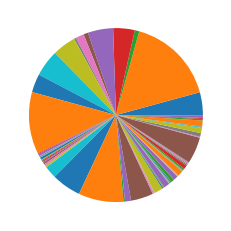

In [13]:
from matplotlib import pyplot as plt

plt.pie(feature_importances)

In [17]:
from sklearn.inspection import permutation_importance
permutation_importance = permutation_importance(best_random_forest, x, y)

In [18]:
permutation_importance_df = pd.Series(permutation_importance.importances_mean, index=pd.Series([col for col in x.columns]))
permutation_importance_df*100

NUM_BENEFICIARIOS_FAMILIA     4.278423
IDADE                         4.641890
SEXO                          1.956055
QTDE_DIAS_ATIVO              20.075934
QTDE_ATENDIMENTOS             2.665804
                               ...    
PLANO_481484183               0.653640
PLANO_481485181               0.126349
PLANO_484629190               0.064132
PLANO_703454997               0.203525
PLANO_OUTROS                  0.029038
Length: 157, dtype: float64

ValueError: Wedge sizes 'x' must be non negative values

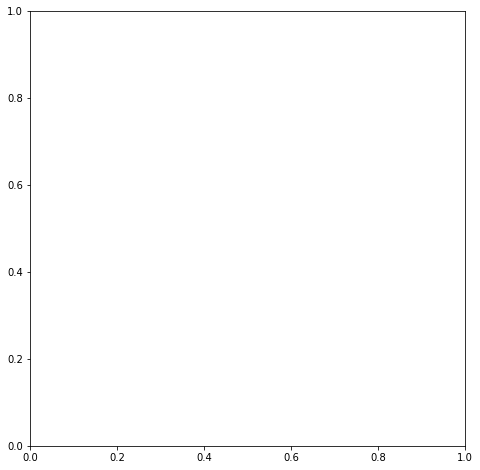

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
plt.pie(permutation_importance_df)
plt.xlabel("Permutation Importance")

In [ ]:
def scores(model):
    model_predicts = model.predict(test_x)
    return accuracy_score(test_y, model_predicts), recall_score(test_y, model_predicts),precision_score(test_y, model_predicts), f1_score(test_y, model_predicts)

In [ ]:

model_scores = {scores(best_random_forest), scores(random_forest_classifier)}
df_model_scores = pd.DataFrame(model_scores, columns=['Acurracy Score', 'Recall Score', 'Precision Score', 'F1 Score'], index=['BRF', 'RFC'])
df_model_scores